In [4]:
from utils import *
import numpy as np

In [5]:
# size of the region of interest
roi_size_px = 332*3
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

# frequency cut-off of the lens (0.33 4xNA lens)
fc_lens = (np.arcsin(.33/4)/lambda_m)
# lens pupil filter in reciprocal space
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
FILTER = (Fx**2 + Fy**2) <= fc_lens**2

In [18]:
pattern = bprp(17, 17)

# BPRP size 17*60nm, corresponding to 17*4 pixels
magnified_pattern = np.kron(pattern+1, np.ones((4, 4)))

# 2.5um spacing between patterns
pattern_size = magnified_pattern.shape[0]
spacing = round(2.5e-6/dx_m) + pattern_size

obj_bprp = np.zeros((roi_size_px, roi_size_px))
width = 3*pattern_size + 2*spacing
shift = (roi_size_px - width) // 2
for i in range(3):
    for j in range(3):
        start_x = i * (pattern_size + spacing) + shift
        start_y = j * (pattern_size + spacing) + shift
        obj_bprp[start_x:start_x+pattern_size, start_y:start_y+pattern_size] = magnified_pattern

obj = obj_bprp

0.283203125


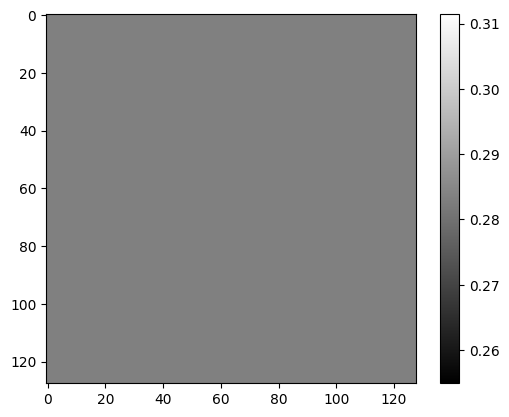

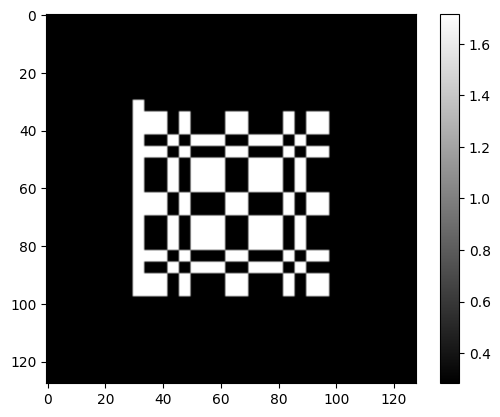

In [22]:
def separate_dc_and_scatter(obj):
    # Apply 2D Fourier Transform
    obj_ft = np.fft.fft2(obj)
    obj_ft_shifted = np.fft.fftshift(obj_ft)

    # Create a mask for the DC component
    rows, cols = obj_ft_shifted.shape
    center_row, center_col = rows // 2, cols // 2
    dc_mask = np.zeros_like(obj_ft_shifted, dtype=bool)
    dc_mask[center_row, center_col] = True

    # Extract DC component
    obj_dc_f = np.zeros_like(obj_ft_shifted)
    obj_dc_f[dc_mask] = obj_ft_shifted[dc_mask]

    # Extract Scatter component
    obj_scatter_f = np.zeros_like(obj_ft_shifted)
    obj_scatter_f[~dc_mask] = obj_ft_shifted[~dc_mask]

    # Shift back if necessary before inverse FT
    obj_dc = np.fft.ifft2(np.fft.ifftshift(obj_dc_f))
    obj_scatter = np.fft.ifft2(np.fft.ifftshift(obj_scatter_f))

    return obj_dc, obj_scatter

center_patch = 256
center_obj= obj[roi_size_px//2-center_patch:roi_size_px//2+center_patch, roi_size_px//2-center_patch:roi_size_px//2+center_patch]
obj_dc, obj_scatter = separate_dc_and_scatter(center_obj)
plt.imshow(np.abs(obj_dc), cmap='gray')
print(np.mean(np.abs(obj_dc)))
plt.colorbar()
plt.show()
plt.imshow(np.abs(obj_scatter), cmap='gray')
plt.colorbar()
plt.show()


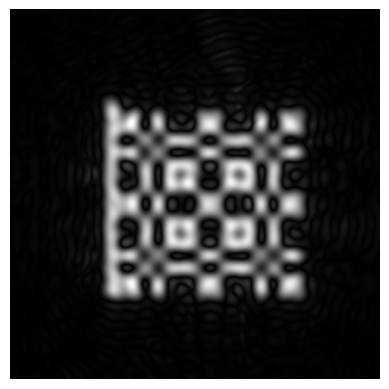

IndexError: boolean index did not match indexed array along dimension 0; dimension is 332 but corresponding boolean dimension is 996

In [6]:
import scipy.io
import glob

keyword = 'bprp_abe00'
folder = f'./sim_data/{keyword}/'
mat = glob.glob(f'{folder}GN*.mat')
recon = scipy.io.loadmat(mat[0])
GN_recon = recon['O']
pupil_recon = recon['P']
# flip pupil to match the convention
pupil_recon = np.fliplr(pupil_recon)
pupil_recon = np.flipud(pupil_recon)

size_px = GN_recon.shape[0]

center_patch = 256
center_obj= GN_recon[size_px//2-center_patch:size_px//2+center_patch, size_px//2-center_patch:size_px//2+center_patch]
plt.imshow(np.abs(center_obj), cmap='gray')
plt.axis('off')
plt.show()

show_aberration(np.angle(pupil_recon), FILTER)



In [7]:
folder = './sim_data/bprp_abe00'
file_path = glob.glob(f"{folder}/*APIC*.mat")
m = scipy.io.loadmat(file_path[0])
apic_recon = m['himMatching']
pupil_recon = m['CTF_abe']
# flip pupil to match the convention
pupil_recon = np.fliplr(pupil_recon)
pupil_recon = np.flipud(pupil_recon)
show_aberration(np.angle(pupil_recon), FILTER)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 332 but corresponding boolean dimension is 996

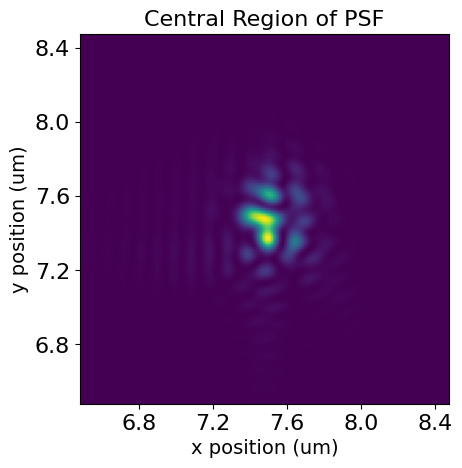

In [8]:
import matplotlib.ticker as ticker

gt_abe = np.load('./sim_data/bprp_abe00/gt_abe.npy')
pupil = FILTER * np.exp(1j * gt_abe)
PSF = np.abs(np.fft.fftshift(np.fft.fft2(pupil)))**2

def plot_central_region(PSF, x_m, y_m, region_size=2e-6):
    # Extract the central region of the PSF
    x_center = (x_m[-1] + x_m[0]) / 2
    y_center = (y_m[-1] + y_m[0]) / 2
    x_indices = np.where((x_m >= x_center - region_size/2) & (x_m <= x_center + region_size/2))
    y_indices = np.where((y_m >= y_center - region_size/2) & (y_m <= y_center + region_size/2))
    central_PSF = PSF[y_indices[0][0]:y_indices[0][-1]+1, x_indices[0][0]:x_indices[0][-1]+1]

    # Option 1: Set font size globally (affects all plots)
    plt.rcParams.update({'font.size': 16})

    # Plot the central region
    plt.imshow(central_PSF, extent=[x_m[x_indices[0][0]]*1e6, x_m[x_indices[0][-1]]*1e6, 
                                    y_m[y_indices[0][0]]*1e6, y_m[y_indices[0][-1]]*1e6])

    # Option 2: Set font size individually (affects only specified elements)
    plt.xlabel('x position (um)', fontsize=14)  # Set fontsize here
    plt.ylabel('y position (um)', fontsize=14)  # Set fontsize here
    plt.title('Central Region of PSF', fontsize=16)  # Set fontsize here

    # To change the font size of tick labels, you can use:
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # 5 ticks max
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # 5 ticks 

    plt.show()

# Example usage with your data:
plot_central_region(PSF, x_m, y_m)


In [24]:
# downsample GN recon
downsampled_size = 996
GN_recon_f = ft(GN_recon)
GN_recon_f = GN_recon_f[size_px//2-downsampled_size//2:size_px//2+downsampled_size//2, size_px//2-downsampled_size//2:size_px//2+downsampled_size//2]
GN_recon = ift(GN_recon_f)

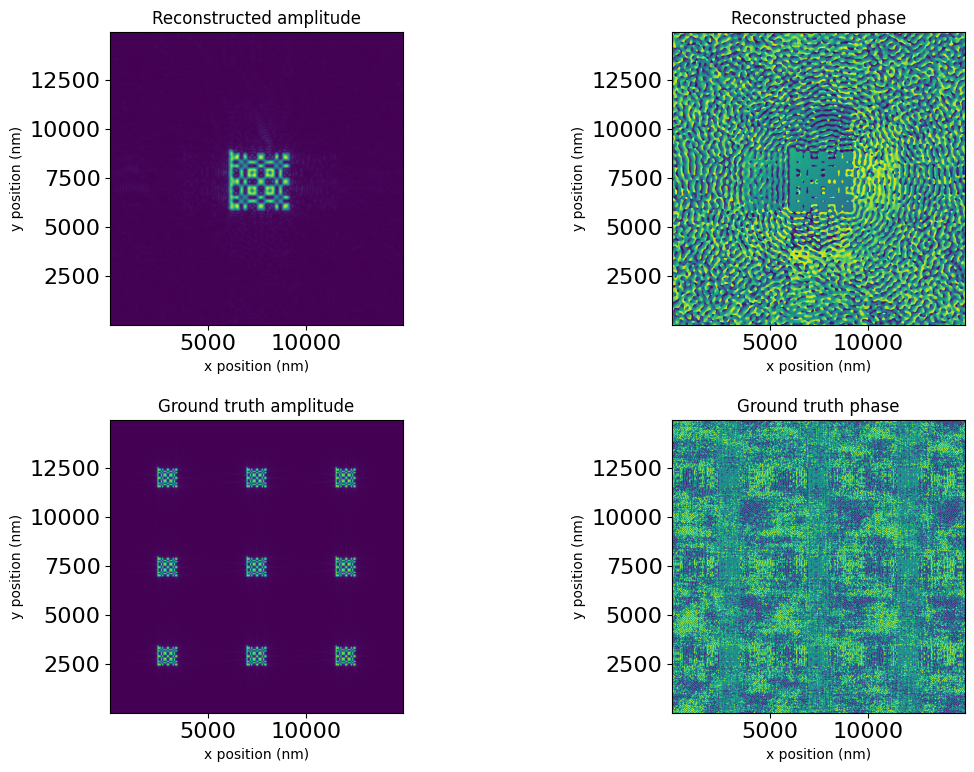

ValueError: operands could not be broadcast together with shapes (1328,1328) (996,996) 

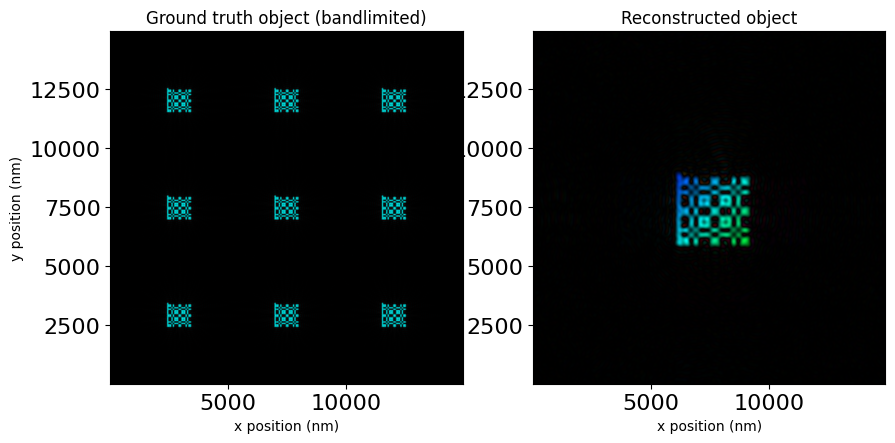

In [9]:
gt_obj = np.load(f'{folder}/gt.npy')
ideal_FILTER = (Fx**2 + Fy**2) <= ((2)*fc_lens)**2
gt_obj = ift(ft(gt_obj)*ideal_FILTER)

plot_gt_cmp(GN_recon, gt_obj, x_m, y_m, freq_cpm, roi_size_px, frc=True)

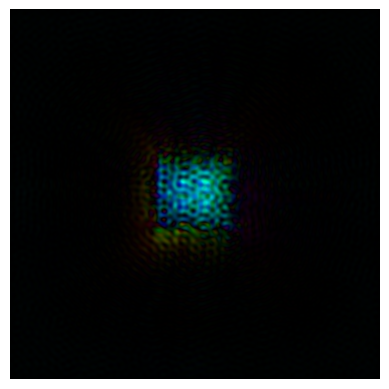

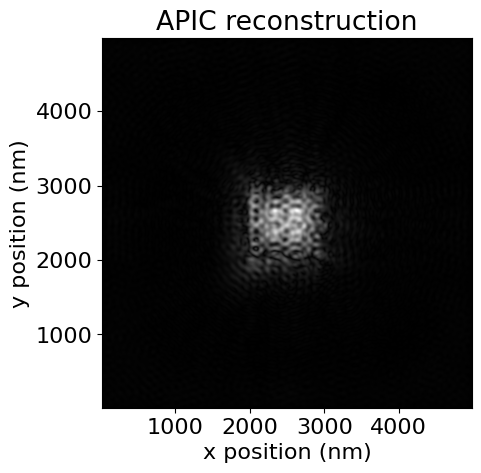

In [12]:
from utils import imagecc
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import glob


folder = './sim_data/bprp_abe00/'
recon_alg = 'APIC'
if recon_alg == 'APIC':
    mat = glob.glob(f'{folder}*APIC*.mat')
    recon = scipy.io.loadmat(mat[0])
    object_guess = recon['himMatching']
    pupil_recon = recon['himAPIC']
    pupil_recon = np.fliplr(pupil_recon)
    pupil_recon = np.flipud(pupil_recon)
# elif recon_alg == 'GN':
#     mat = glob.glob(f'{folder}GN*.mat')
#     recon = scipy.io.loadmat(mat[0])
#     object_guess = recon['O']
#     pupil_recon = recon['P']
#     pupil_recon = np.fliplr(pupil_recon)
#     pupil_recon = np.flipud(pupil_recon)
else:
    object_guess = np.load(f'{folder}/result/{recon_alg}_recon.npy')


roi_size_px = 332
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

plt.imshow(imagecc(object_guess))
# plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
# plt.xlabel('x position (nm)')
# plt.ylabel('y position (nm)')
# plt.title(f'{recon_alg} Reconstructed object')
plt.axis('off')
plt.show()

plt.imshow(np.abs(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title(f'{recon_alg} reconstruction')
plt.show()


Using ROI of size 332


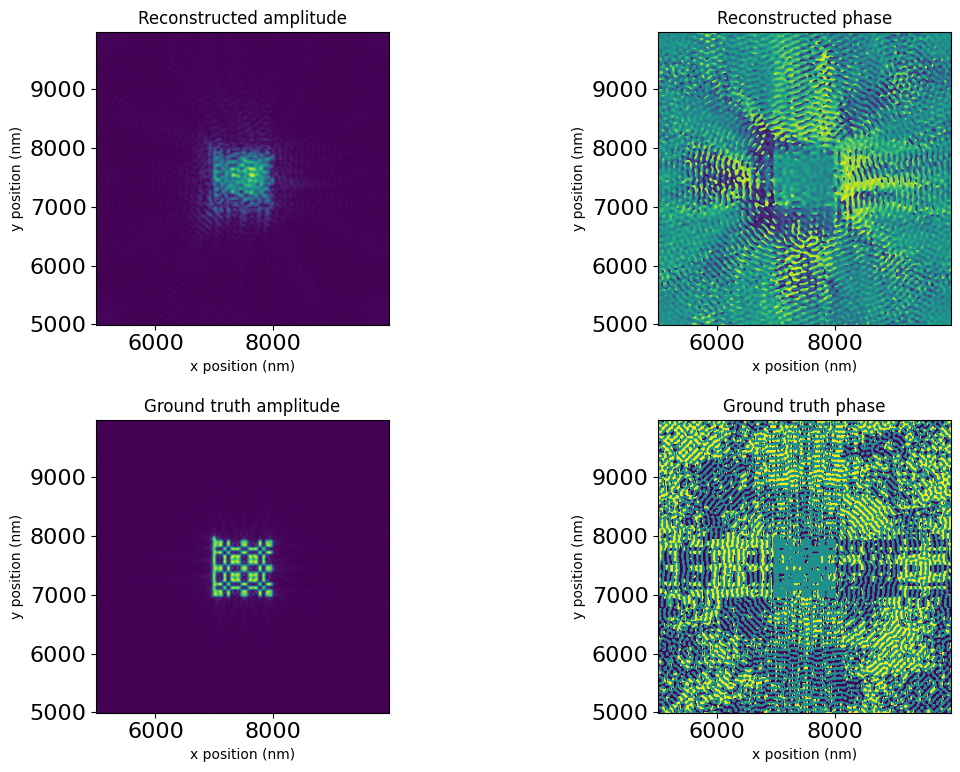

ValueError: operands could not be broadcast together with shapes (996,996) (332,332) 

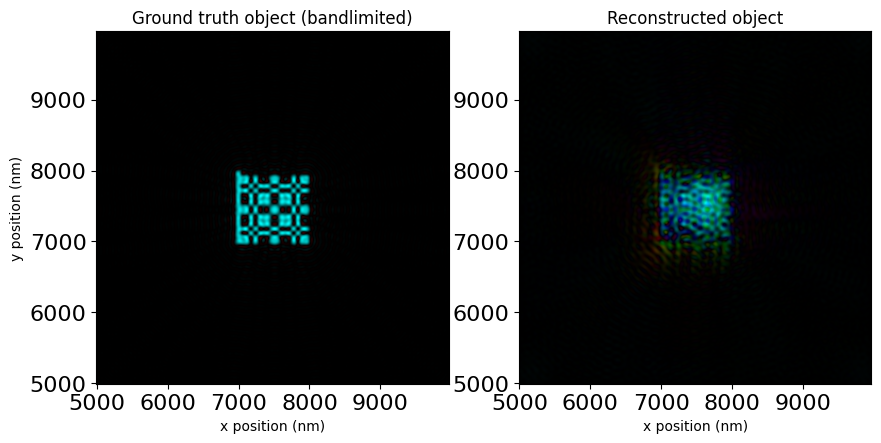

In [36]:
from utils import *

gt_obj = np.load(f'{folder}/gt.npy')
use_ROI = True
ROI_length = 332
roi_size_px = 332*3
ROI_center =  [int(roi_size_px/2), int(roi_size_px/2)]

dx_m = 15e-9
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

lambda_m = 13.5e-9
fc_lens = (np.arcsin(.33/4)/lambda_m)

if use_ROI:
    print(f'Using ROI of size {ROI_length}')
    x_m = x_m[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2)]
    y_m = y_m[ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]
    gt_obj = gt_obj[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2), 
             ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]
       
    roi_size_px = min(ROI_length, roi_size_px)
    Dx_m = ROI_length * dx_m
    Nfft = len(x_m)
    fs = 1 / (x_m[1] - x_m[0])
    df = fs / Nfft
    freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
    Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
    FILTER = (Fx**2 + Fy**2) <= fc_lens**2

ideal_FILTER = (Fx**2 + Fy**2) <= ((2)*fc_lens)**2
gt_obj = ift(ft(gt_obj)*ideal_FILTER)


plot_gt_cmp(object_guess, gt_obj, x_m, y_m, freq_cpm, roi_size_px, frc=True)

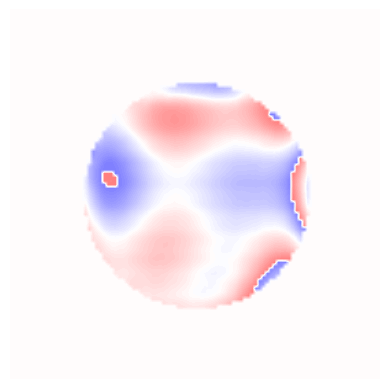

In [53]:
def show_phase(phase):
    # color map
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> W -> B
    cmap_name = 'custom_diverging'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    # crop center region
    range = 150
    size = phase.shape[0]
    img = phase[size//2-range:size//2+range, size//2-range:size//2+range]

    plt.imshow(img, cmap=cm, vmin=-2.0*np.pi, vmax=2.0*np.pi)
    plt.axis('off')
    plt.show()


gt_abe = np.load(f'{folder}/gt_abe.npy')

recon_alg = 'EPFR' 
if recon_alg == 'APIC':
    mat = glob.glob(f'{folder}*APIC*.mat')
    recon = scipy.io.loadmat(mat[0])
    object_guess = recon['himMatching']
    pupil_recon = recon['CTF_abe']
    pupil_recon = np.fliplr(pupil_recon)
    pupil_recon = np.flipud(pupil_recon)
    abe = -np.angle(pupil_recon) * FILTER
    import cv2
    # upsample abe by 3 times
    abe = cv2.resize(abe, (abe.shape[1]*3, abe.shape[0]*3), interpolation=cv2.INTER_LINEAR)
    
elif recon_alg == 'GN' or recon_alg == 'EPFR':
    pupil_recon = np.load(f'{folder}/result/{recon_alg}_abe.npy')
    # pupil_recon = np.fliplr(pupil_recon)
    # pupil_recon = np.flipud(pupil_recon)
    abe = pupil_recon
    import cv2
    # upsample abe by 3 times
    abe = cv2.resize(abe, (abe.shape[1]*3, abe.shape[0]*3), interpolation=cv2.INTER_LINEAR)

show_phase(abe)


In [ ]:
def load_recon(folder, recon_alg):
    if recon_alg == 'APIC':
        mat = glob.glob(f'{folder}*APIC*.mat')
        recon = scipy.io.loadmat(mat[0])
        object_guess = recon['himMatching']
        pupil_recon = recon['himAPIC']
        pupil_recon = np.fliplr(pupil_recon)
        pupil_recon = np.flipud(pupil_recon)
    # elif recon_alg == 'GN':
    #     mat = glob.glob(f'{folder}GN*.mat')
    #     recon = scipy.io.loadmat(mat[0])
    #     object_guess = recon['O']
    #     pupil_recon = recon['P']
    #     pupil_recon = np.fliplr(pupil_recon)
    #     pupil_recon = np.flipud(pupil_recon)
    else:
        object_guess = np.load(f'{folder}/result/{recon_alg}_recon.npy')
        
    if recon_alg == 'GN' or recon_alg == 'APIC':
        downsampled_size = 332
        size_px = object_guess.shape[0]
        object_guess = ft(object_guess)
        object_guess = object_guess[size_px//2-downsampled_size//2:size_px//2+downsampled_size//2, size_px//2-downsampled_size//2:size_px//2+downsampled_size//2]
        object_guess = ift(object_guess)
    
    return object_guess

GN_recon = load_recon(folder, 'GN')
APIC_recon = load_recon(folder, 'APIC')
GS_recon = load_recon(folder, 'GS')
EPFR_recon = load_recon(folder, 'EPFR')

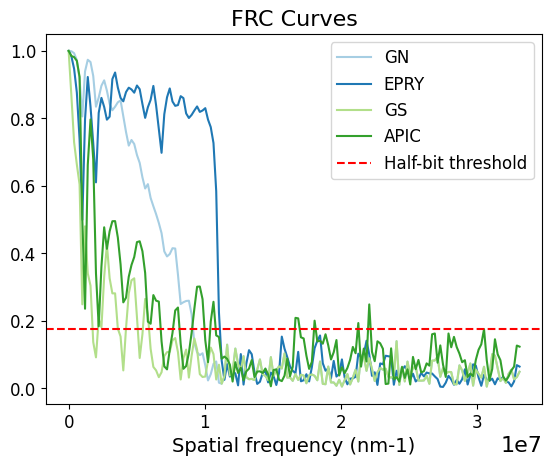

In [34]:
f1, halfbit_threshold = frc(gt_obj, GN_recon)
f2, _ = frc(gt_obj, EPFR_recon)
f3, _ = frc(gt_obj, GS_recon)
f4, _ = frc(gt_obj, APIC_recon)

pastel1 = plt.colormaps.get_cmap('Paired')

plt.figure()

# Plot lines
plt.plot(freq_cpm[roi_size_px//2:], f1, label='GN', color=pastel1(0))
plt.plot(freq_cpm[roi_size_px//2:], f2, label='EPRY', color=pastel1(1))
plt.plot(freq_cpm[roi_size_px//2:], f3, label='GS', color=pastel1(2))
plt.plot(freq_cpm[roi_size_px//2:], f4, label='APIC', color=pastel1(3))

# Labels and title with increased font size
plt.xlabel('Spatial frequency (nm-1)', fontsize=14)
plt.title('FRC Curves', fontsize=16)

# Half-bit threshold line
plt.axhline(halfbit_threshold, color='r', linestyle='--', label='Half-bit threshold')

# Increase font size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend with increased font size
plt.legend(fontsize=12)

plt.show()

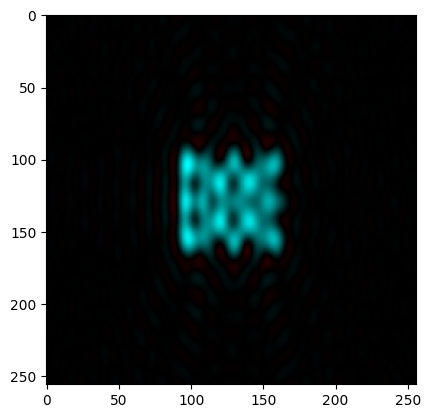

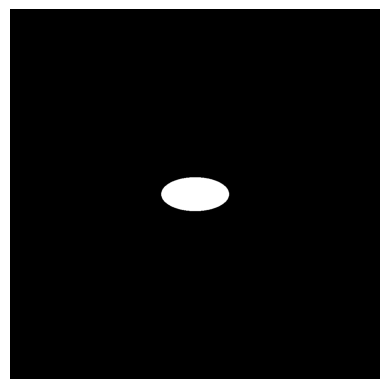

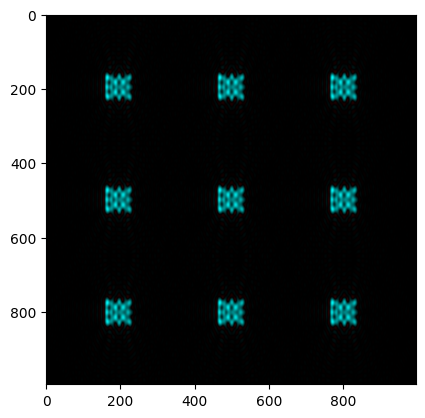

In [23]:
import numpy as np
import scipy.io
from utils import *
folder = './sim_data/bprp_abe00/'
keyword = 'bprp_abe00'
recon_alg = 'GS'
object_guess = np.load(f'{folder}/result/{recon_alg}_recon.npy')


roi_size_px = 332*3
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m


data = scipy.io.loadmat(f'{folder}{keyword}.mat')
ideal_filter = data['ideal_CTF']


lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

# frequency cut-off of the lens (0.33 4xNA lens)
fc_lens = (np.arcsin(.33/4)/lambda_m)
# lens pupil filter in reciprocal space
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
# FILTER = (Fx**2 + Fy**2) <= fc_lens**2
a = fc_lens  # semi-major axis
b = fc_lens / 2  # semi-minor axis
FILTER = ((Fx/a)**2 + (Fy/b)**2) <= 1





gt_obj = np.load(f'{folder}/gt.npy')
gt_obj = ift(ft(gt_obj)*FILTER)
center_patch = 128
center_obj= gt_obj[roi_size_px//2-center_patch:roi_size_px//2+center_patch, roi_size_px//2-center_patch:roi_size_px//2+center_patch]


plt.imshow(imagecc(center_obj))
plt.show()





plt.imshow(FILTER, cmap='gray')
plt.axis('off')
plt.show()


plt.imshow(imagecc(gt_obj))
plt.show()


# Full-tile dataset recon visualization

full recon visualization

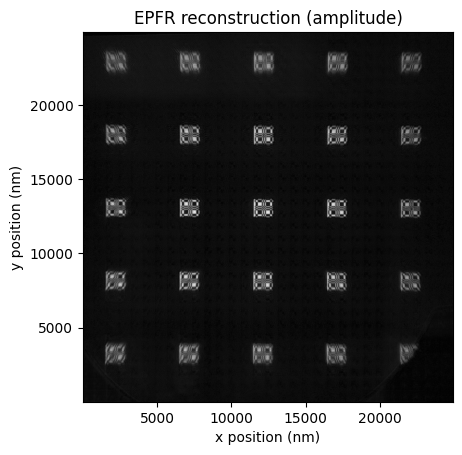

In [28]:
import numpy as np
import scipy.io
from utils import *
folder = './real_data/full_tile/'
recon_alg = 'EPFR'
object_guess = np.load(f'{folder}/result/{recon_alg}_full_recon.npy')

roi_size_px = 332*5
# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m
# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m


plt.imshow(np.abs(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title(f'{recon_alg} reconstruction (amplitude)')
plt.show()

# save to full resolution image
import imageio
norm_image = np.abs(object_guess)**2
norm_image = (255*norm_image/np.max(norm_image)).astype(np.uint8) 
imageio.imwrite(f'{folder}/result/recon.png', norm_image)


find low-res (central illumination) meas for comparison

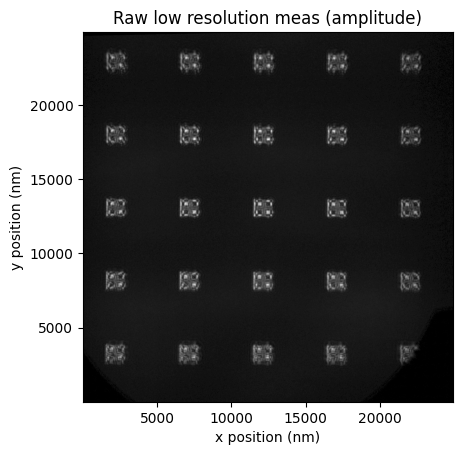

In [33]:
import os
import glob
from PIL import Image
files = glob.glob(os.path.join(folder, "*.png"))

for filename in files:
    img_0 = np.array(Image.open(filename)).astype(float)
    filename = os.path.basename(filename)
    sx_0 = float(filename[-17:-12])
    sy_0 = float(filename[-9:-4])
    if (np.abs(sx_0)< 1e-5) & (np.abs(sy_0)< 1e-5):
        img = img_0
        break

plt.imshow(np.sqrt(np.abs(img)), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title(f'Raw low resolution meas (amplitude)')
plt.show()
object_guess = np.sqrt(np.abs(img))

patch visualization

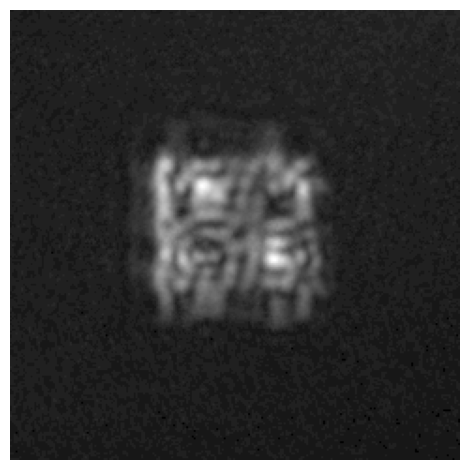

In [34]:
# top left corner
# patch = np.abs(object_guess)[10:250, 30:270]
# patch = np.abs(object_guess)[40:1000, 120:1080]

# bottom right corner
patch = np.abs(object_guess)[332*4:332*4+240, 332*3+20:332*3+260]
# patch = np.abs(object_guess)[332*4*4:(332*4+240)*4, (332*3+20)*4:(332*3+260)*4]

# central region
# patch = np.abs(object_guess)[332*2:332*2+240, 332*2+30:332*2+270]

plt.imshow(patch, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

FRC plot

In [35]:
from utils import frc_plot, frc, circshift2

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = 240
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

def get_frc_patch(object_guess):
    # top left corner
    # patch1 = object_guess[10:250, 30:270]
    # bottom right corner
    patch1 = object_guess[332*4:332*4+240, 332*3+20:332*3+260]
    
    # central region
    patch2 = object_guess[332*2:332*2+240, 332*2+30:332*2+270]


    # register the two patches by finding the maximum of the cross-correlation
    min_ssd = np.inf
    for x_shift in range(-20,20):
        for y_shift in range(-20,20):
            patch2_shifted = circshift2(patch2, x_shift, y_shift)
            # calculate SSD
            ssd = np.sum((np.abs(patch1) - np.abs(patch2_shifted))**2)
            if ssd < min_ssd:
                min_ssd = ssd
                best_x_shift = x_shift
                best_y_shift = y_shift
    print(f'Best shift: {best_x_shift}, {best_y_shift}')
    patch2 = circshift2(patch2, best_x_shift, best_y_shift)
    return patch1, patch2

patch1_raw, patch2_raw = get_frc_patch(object_guess)

recon_alg = 'EPFR'
object_guess = np.load(f'{folder}/result/{recon_alg}_full_recon.npy')
patch1_epf, patch2_epf = get_frc_patch(object_guess)

recon_alg = 'GN'
object_guess = np.load(f'{folder}/result/{recon_alg}_full_recon.npy')
patch1_gnf, patch2_gnf = get_frc_patch(object_guess)

recon_alg = 'GN'
object_guess = np.load(f'{folder}/result/{recon_alg}_recon.npy')
# 4x downsampling
object_guess = object_guess[::4, ::4]
patch1_gn, patch2_gn = get_frc_patch(object_guess)

recon_alg = 'GS'
object_guess = np.load(f'{folder}/result/{recon_alg}_recon.npy')
patch1_gs, patch2_gs = get_frc_patch(object_guess)



Best shift: 7, -9
Best shift: 6, -10
Best shift: 5, -15
Best shift: 6, -10
Best shift: 6, -6


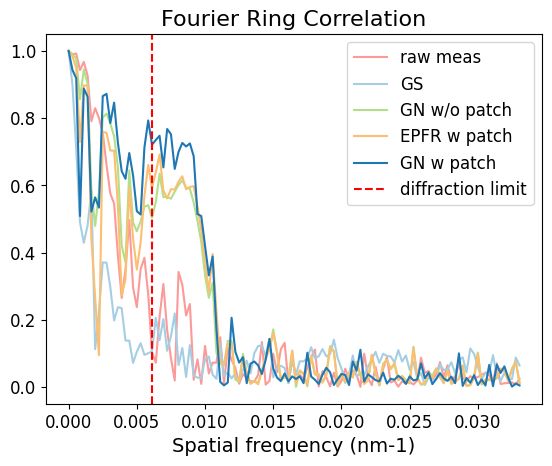

In [43]:
f1, halfbit_threshold = frc(patch1_gs, patch2_gs)
f2, _ = frc(patch1_gn, patch2_gn)
f3, _ = frc(patch1_gnf, patch2_gnf)
f4, _ = frc(patch1_raw, patch2_raw)
f5, _ = frc(patch1_epf, patch2_epf)

pastel1 = plt.colormaps.get_cmap('Paired')

roi_size_px = 240

plt.figure()

# Plot lines
plt.plot(freq_cpm[roi_size_px//2:]/1e9, f4, label='raw meas', color=pastel1(4))
plt.plot(freq_cpm[roi_size_px//2:]/1e9, f1, label='GS', color=pastel1(0))
plt.plot(freq_cpm[roi_size_px//2:]/1e9, f2, label='GN w/o patch', color=pastel1(2))
plt.plot(freq_cpm[roi_size_px//2:]/1e9, f5, label='EPFR w patch', color=pastel1(6))
plt.plot(freq_cpm[roi_size_px//2:]/1e9, f3, label='GN w patch', color=pastel1(1))

# Labels and title with increased font size
plt.xlabel('Spatial frequency (nm-1)', fontsize=14)
plt.title('Fourier Ring Correlation', fontsize=16)

# Half-bit threshold line
# plt.axhline(halfbit_threshold, color='r', linestyle='--', label='Half-bit threshold')

# Diffraction limit line
lambda_m = 13.5e-9
fc_lens = np.arcsin(.33/4)/lambda_m
plt.axvline(fc_lens/1e9, color='r', linestyle='--', label='diffraction limit')

# Increase font size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend with increased font size
plt.legend(fontsize=12)

plt.show()

calib data FRC

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils import frc

# effective pixel size
dx_m = 15e-9

# patch size
roi_size_px = 240

fs = 1 / dx_m
Nfft = roi_size_px
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

folder = './real_data/full_tile_calib/'
files = glob.glob(os.path.join(folder, "*.png"))

img = []
for filename in files:
    img_0 = np.array(Image.open(filename)).astype(float)
    img.append(img_0)

num_img = len(img)

def get_curve(index1, index2):
    patch1 = img[index1][332*2:332*2+240, 332*2+30:332*2+270]
    patch2 = img[index2][332*2:332*2+240, 332*2+30:332*2+270]
    f, _ = frc(patch1, patch2)
    return f


x_values = freq_cpm[roi_size_px//2:]/1e9
min_y_values = np.inf * np.ones_like(x_values)
max_y_values = -np.inf * np.ones_like(x_values)


for index1 in range(num_img):
    for index2 in range(num_img):
        if index1 == index2:
            continue
        y_values = get_curve(index1, index2)
        min_y_values = np.minimum(min_y_values, y_values)
        max_y_values = np.maximum(max_y_values, y_values)


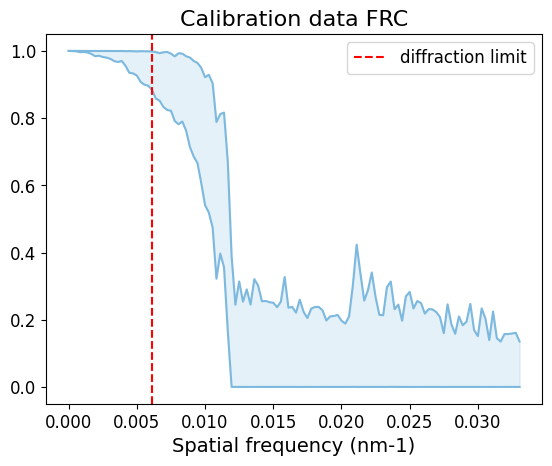

In [41]:
plt.figure()

plt.fill_between(x_values, min_y_values, max_y_values, color='#7DB9DE', alpha=0.2)  # Light blue fill
plt.plot(x_values, min_y_values, color='#7DB9DE')  # Deeper blue for min envelope
plt.plot(x_values, max_y_values, color='#7DB9DE') 

plt.xlabel('Spatial frequency (nm-1)', fontsize=14)
plt.title('Calibration data FRC', fontsize=16)

# Diffraction limit line
lambda_m = 13.5e-9
fc_lens = np.arcsin(.33/4)/lambda_m
plt.axvline(fc_lens/1e9, color='r', linestyle='--', label='diffraction limit')

# Increase font size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  

plt.legend(fontsize=12)

plt.show()


FRC altogether

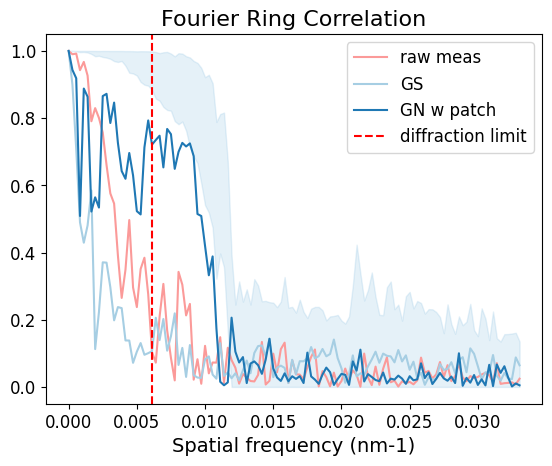

In [40]:
plt.figure()

# Plot lines

plt.fill_between(x_values, min_y_values, max_y_values, color='#7DB9DE', alpha=0.2)  # Light blue fill


plt.plot(freq_cpm[roi_size_px//2:]/1e9, f4, label='raw meas', color=pastel1(4))
plt.plot(freq_cpm[roi_size_px//2:]/1e9, f1, label='GS', color=pastel1(0))
plt.plot(freq_cpm[roi_size_px//2:]/1e9, f3, label='GN w patch', color=pastel1(1))

# Labels and title with increased font size
plt.xlabel('Spatial frequency (nm-1)', fontsize=14)
plt.title('Fourier Ring Correlation', fontsize=16)

# Half-bit threshold line
# plt.axhline(halfbit_threshold, color='r', linestyle='--', label='Half-bit threshold')

# Diffraction limit line
lambda_m = 13.5e-9
fc_lens = np.arcsin(.33/4)/lambda_m
plt.axvline(fc_lens/1e9, color='r', linestyle='--', label='diffraction limit')

# Increase font size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend with increased font size
plt.legend(fontsize=12)

plt.show()

# Aberration visualization

patch recon aberration visualization

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


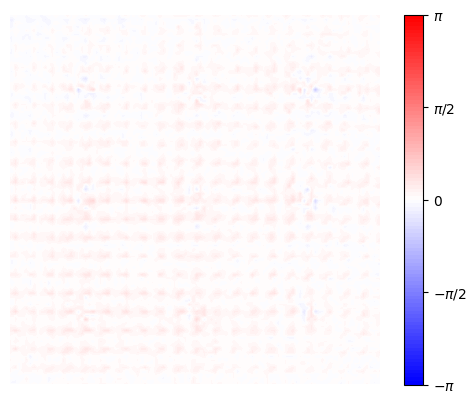

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.io
import glob



def show_phase(phase):
    # color map
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> W -> B
    cmap_name = 'custom_diverging'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    # crop center region
    range = 150
    size = phase.shape[0]
    img = phase[size//2-range:size//2+range, size//2-range:size//2+range]

    fig, ax = plt.subplots()
    cax = ax.imshow(img, cmap=cm, vmin=-np.pi, vmax=np.pi)  # Adjust the limits to -pi to pi for your use case
    plt.axis('off')
    
    # Create colorbar
    cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$']) 
    
    plt.show()



folder = './real_data/full_tile/'
recon_alg = 'GN' 
if recon_alg == 'APIC':
    mat = glob.glob(f'{folder}*APIC*.mat')
    recon = scipy.io.loadmat(mat[0])
    object_guess = recon['himMatching']
    pupil_recon = recon['CTF_abe']
    pupil_recon = np.fliplr(pupil_recon)
    pupil_recon = np.flipud(pupil_recon)
    abe = -np.angle(pupil_recon) * FILTER
    import cv2
    # upsample abe by 3 times
    abe = cv2.resize(abe, (abe.shape[1]*3, abe.shape[0]*3), interpolation=cv2.INTER_LINEAR)
    
elif recon_alg == 'GN' or recon_alg == 'EPFR':
    pupil_recon = np.load(f'{folder}/result/{recon_alg}_abe.npy')
    # pupil_recon = np.fliplr(pupil_recon)
    # pupil_recon = np.flipud(pupil_recon)
    abe = pupil_recon
    import cv2
    # upsample abe by 3 times
    abe = cv2.resize(abe, (abe.shape[1]*3, abe.shape[0]*3), interpolation=cv2.INTER_LINEAR)

show_phase(abe)

full FoV aberration visualization

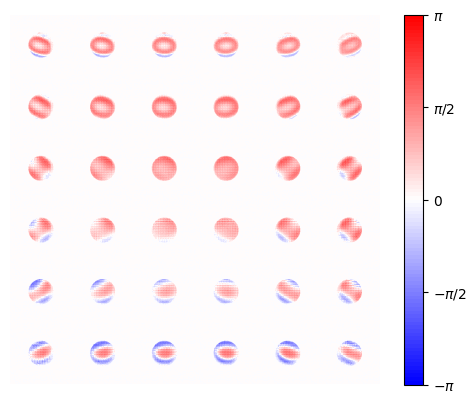

In [5]:
recon_alg = 'GN'
abe_arr = np.load(f'{folder}/result/{recon_alg}_full_pupil.npy')

size = 150 
start_idx = (332 - size) // 2
end_idx = start_idx + size
central_abe_arr = abe_arr[:, :, start_idx:end_idx, start_idx:end_idx]


full_abe = np.block([[central_abe_arr[i, 5-j] for j in range(6)] for i in range(6)])




# color map
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> W -> B
cmap_name = 'custom_diverging'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

fig, ax = plt.subplots()
cax = ax.imshow(full_abe, cmap=cm, vmin=-np.pi, vmax=np.pi)  # Adjust the limits to -pi to pi for your use case
plt.axis('off')

# Create colorbar
cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$']) 

plt.show()
